# General Bellman Stage Form

_Notebook by Sebastian Benthall_

In [1]:
from dataclasses import dataclass, field

import itertools
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from typing import Any, Callable, Mapping, Sequence
import xarray as xr

from HARK import distribution
from HARK.utilities import CRRAutility, CRRAutilityP, CRRAutility_inv

In [2]:
from HARK.stage import Stage, backwards_induction, simulate_stage

In [3]:
## Doing this because of the CRRAutility warnings

import warnings
warnings.filterwarnings('ignore')

This notebook demonstrates HARK's ability to represent and compose Bellman stages.
This is possible because all Bellman stages have a general form.

In each Bellman stage $(\vec{X}, P_\vec{K}, \vec{A}, \Gamma, F, \vec{Y}, T, \beta)$, the agent:
 - begins in some input states $\vec{x} \in \vec{X}$
 - experiences some exogeneous shocks $\vec{k} \in \vec{K}$ according to distribution $P_\vec{K}$
 - can choose some actions $\vec{a} \in \vec{A}$
 - subject to constraints $\Gamma: \vec{X} \times \vec{K} \rightarrow \mathcal{P}(\vec{A})$
     - For scalar actions, these may be expressed as upper and lower bounds, such that $\Gamma_{lb} \leq a \leq \Gamma_{ub}$:
         - $\Gamma_{ub}: \vec{X} \times \vec{K} \rightarrow \mathbb{R}$
         - $\Gamma_{lb}: \vec{X} \times \vec{K} \rightarrow \mathbb{R}$
         - such that $\Gamma(\vec{x}, \vec{k}) = [\Gamma_{lb}(\vec{x}, \vec{k}), \Gamma_{ub}(\vec{x}, \vec{k})]$
 - experience a reward $F: \vec{X} \times \vec{K} \times \vec{A} \rightarrow \mathbb{R}$
 - together, these determine some output states $\vec{y} \in \vec{Y}$ via...
 - a **deterministic** transition function $T: \vec{X} \times \vec{K} \times \vec{A} \rightarrow \vec{Y}$
   - _This is deterministic because shocks have been isolated to the beginning of the stage._
 - The agent has a discount factor $\beta$ for future utility.
     - This is often a constant $\beta$
     - but it can also be a function $\beta: \vec{X} \times \vec{K} \times \vec{A} \rightarrow \mathbb{R}$

## Solving one stage 

### Value update

For any stage, consider two value functions.
 - $v_x : X \rightarrow \mathbb{R}$ is the value of its input states.
 - $v_y : Y \rightarrow \mathbb{R}$ is the value of its output states. Others migth write this $\mathfrak{v}$'
 
The stage is solved with respect to a value function $v_y : \vec{Y} \rightarrow \mathbb{R}$ over the output states. The $q: \vec{X} \times \vec{K} \times \vec{A} \rightarrow \mathbb{R}$ is the action-value of a state, shock, action combination.

$$q(\vec{x}, \vec{k}, \vec{a}) = F(\vec{x}, \vec{k}, \vec{a}) + \beta(\vec{x},\vec{k},\vec{a}) v_y(T(\vec{x}, \vec{k}, \vec{a}))$$

where $\beta$ is the agent's discount factor for that stage. Note that there is no expectation taking in this operation because $T$ is deterministic.

The optimal policy $\pi: \vec{X} \times \vec{K} \rightarrow \vec{A}$ is:

$$\pi^*(\vec{x}, \vec{k}) = \underset{\vec{a} \in \Gamma(\vec{x}, \vec{k})}{\mathrm{argmax}} q(\vec{x}, \vec{k}, \vec{a})$$

The optimal policy $\pi^*$ can then be used to derive the value function over the input states $V_x: \vec{X} \rightarrow \mathbb{R}$.

$$v_x(\vec{x}) = \mathbb{E}_{\vec{k} \in \vec{K}}[q(\vec{x}, \vec{k}, \pi^*(\vec{x}, \vec{k}))]$$

Note that this requires no optimization, but does require the taking of expectations over the probability distribution over the shocks.

### Marginal value update

It is sometimes useful to consider that the optimization step above truly depends on the marginal value function $v'_y$, and not on $v_y$ (i.e., the solution is indifferent to an additive constant on $v_y$. This is because interpolation can introduce errors, and interpolating $v'_y$ can introduce fewer errors than interpolating $v_y$.
 
Consider what we can do under the following conditions:

 - Given $v'_y : Y \rightarrow \mathbb{R}$ is the value of its output states. Others migth write this $\mathfrak{v}$'
 - Discount factor $\beta$ does not depend on $\vec{a}$, i.e. because it is constant.
 - Marginal reward function $F' = \frac{\partial F}{\partial \vec{a}}$
 
Assuming the $q$ function is concave, then the optimal $\pi^*(\vec{x}, \vec{k}) \in \vec{A}$ will satisfy the first order condition (FOC). This condition is that the marginal action value function $q' =  \frac{\partial q}{\partial \vec{a}}$ is 0:

$$0 = q'(\vec{x}, \vec{k}, \vec{a})$$

$$0 = F'(\vec{x}, \vec{k}, \vec{a}) + \beta(\vec{x},\vec{k},\vec{a}) v_y'(T(\vec{x}, \vec{k}, \vec{a}))$$

(This condition is more complex if $\beta$ depends on the actions because of the Product Rule of differentiation.)

If $q'(\vec{x}, \vec{k}, \Gamma_{lb}(\vec{x}, \vec{k}))$ and $q'(\vec{x}, \vec{k}, \Gamma_{ub}(\vec{x}, \vec{k}))$ have the same sign, then the constraints bind, and $\pi^*(\vec{x}, \vec{k}) = \Gamma_{lb}(\vec{x}, \vec{k})$ (negative sign) or $\pi^*(\vec{x}, \vec{k}) = \Gamma_{ub}(\vec{x}, \vec{k})$ (positive sign).

**TODO: Nice LaTeX braces and cases for this?**

Computationally, this involves replacing the numerical optimization step with a numerical root-finding step.

Once $\pi^*$ has been identified, the marginal input value function can be computed by taking the expectation of the optimal marginal action values:

$$v'_x(\vec{x}) = \mathbb{E}_{\vec{k} \in \vec{K}}[q'(\vec{x}, \vec{k}, \pi^*(\vec{x}, \vec{k}))]$$

### TODO: General EGM?

When:
 - $F(\vec{x}, \vec{k}, \vec{a}) = F(\vec{a})$
 - $\beta(\vec{x},\vec{k},\vec{a}) = \beta$
 
Then we can derive from the FOC that:

$$\pi^*_y(\vec{y})  =  F'^{-1}(\beta v_y'(\vec{y}))$$

This creates an 'endogenous grid' over the action space $\vec{A}$.

**TODO: Need notation for grids. (See below for an attempt).**

**TODO: What happens if $\vec{y}$ is multidimensional? Is it e.g. $\frac{\partial v_y'(\vec{y})}{\partial y_1 \partial y_2}$?**

With an invertible transition function so that $T^{-1}: \vec{Y} \times \vec{A} \rightarrow \vec{X} \times \vec{K} $ is well defined, then $T^{-1}(\vec{y}, \vec{\pi^*_y(\vec{y})}) = (x_y, k_y)$ establishes a grid over $\vec{X}. \vec{K}$, and $v'_x(x_y) = F'(\pi^*_y(y)$ is an easy computation of the marginal value function.

**TODO: Can the conditions for EGM as applied to a stage be broadened?**

## Grids, Special Points, and Interpolation

In practice, we will solve a discretized version of the problem.

We will always have a grid of values $\{\vec{x}_i\} \subset \vec{X}$ and $\{\vec{k}_i\} \subset \vec{K}$ over which the values of $\pi^*$ and $q(\vec{x}, \vec{k}, \pi^*(\vec{x}, \vec{k}))$ can be computed.

The value function $v_x$ is then computed by taking the expectation over the discretized shock values.

The fully functions of $\pi^*$, $q$, and $v_x$ are then recovered through approximation by interpolation.

Interpolation brings with it a host of challenges when the underlying functions are very curved.

For example, with a CRRA utility function the utility of consuming $0$ resources is $-\infty$. This means both that linear extrapolation from low-but-positive values will be too high, and that when an agent has no choice but to consume 0 resources they will be impossibly miserable.

For this reason we offer a few tricks:

### Transformed value function interpolation

Rather than requiring users to use a linearly interpolated value function $v_x \sim i(\vec{v_x})$, we allow the user to define a transform function $f$ and its inverse $f^{-1}$ such that $v_x \sim f^{-1}(i(f(\vec{v_x})))$.

Commonly, the transformation function $f$ is the inverse of the CRRA utility function.

It can also be exponentiation $e^x$, which is a similar operation. **TODO: What are the theoretical advantages of the inverse utility function over e^x?**

### Solution Points

When it is easy to determine the optimal policy $\pi^*$ or value function $v_x$ for a particular state $x^*$ analytically, but difficult to solve it using optimization, it is useful to input that value directly in the stage definition.

# Portfolio Choice Problem

We demonstrate the expressivity of the general Bellman stage form by representing a well-understood problem, the Portfolio Choice problem.

In this intertemporal choice problem, the agent has two decisions to make at each time step: $c$, how many resources to consume; and $\alpha$, what proportion of their savings to allocate to a risky asset. They earn income every time period; this income is subject to permanent ($\psi$) and transitory ($\theta$) shocks. The risky asset's growth is also subject to a shock ($\eta$). The agent is rewarded for consumption through a CRRA utility function governed by $\rho$.

This problem is implemented and analyzed in other HARK materials. In this notebook, we focus on representing the problem as a series of Bellman stages of the above form, implementing them using HARK's `stage` module, and solving the composed problem with a generic value iteration algorithm.

### A few hacks

We have a small technical problem which is that the CRRA utility function has a value of $-\infty$ when consumption is 0, and this throws off the optimizers.

As a hack, we will define $\epsilon$ (`epsilon` in Python) for the minimum value of resources/consumption that we will use in the discretization of the resource space.

In [4]:
epsilon = 1e-4

HARK's `CRRAutility` does not work with an input of 0. We will patch it to fix this.

In [5]:
CRRAutility_hack = lambda c, gam: float('-inf') if c == 0.0 else CRRAutility(c, gam)
CRRAutilityP_hack = lambda c, gam: float('inf') if c == 0.0 else CRRAutilityP(c, gam)

## Stages

First we define the stages. Then we combine the stages together and solve them recursively.

### Consumption stage

The consumption stage:

* $c \in A_0 = \mathbb{R}$
* $m \in X_0 = \mathbb{R}$
* $a \in Y_0 = \mathbb{R}$
* $\Gamma_0$ ... restricts consumption $c \leq m$
* $F_0(m,c) = CRRA(c, \rho)$
* $T_0(m,c) = m - c$ 
* $\beta_0 = \beta $

Requires a parameter $\rho$

In [6]:
CRRA = 5.0

consumption_stage = Stage(
    ##### Stage Definition -- math!
    transition = lambda x, k, a : {'a' : x['m'] - a['c']}, 
    reward = lambda x, k, a : CRRAutility_hack(a['c'], CRRA),
    reward_der = lambda x, k, a: CRRAutilityP_hack(a['c'], CRRA),
    inputs = ['m'], 
    actions = ['c'],
    outputs = ['a'],
    action_upper_bound = lambda x, k: (x['m'],) , 
    action_lower_bound = lambda x, k: (0,) , 
    discount = .96, # Here, this is just a subjective discount rate.
    
    ##### Inputs to optimizers, interpolators, solvers...
    optimizer_args = {
        'method' : 'Nelder-Mead',
        'options' : {
            'maxiter': 1e3,
            #'disp' : True
        }
    },
    
    value_transform = np.exp, # lambda c: CRRAutility_inv(c, CRRA),
    value_transform_inv = np.log, # lambda c : CRRAutility_inv(c, CRRA),
    
    # Pre-computed points for the solution to this stage
    solution_points = xr.Dataset(
        data_vars={
            'v_x' : (["m"], [-float('inf')]),
            'v_x_der' : (["m"], [float('inf')]),
            'pi*' : (["m"], [0]),
            #'q' : (["m"], [-float('inf')]),
        },
        coords={
            'm' : (["m"], [0]),
        }
    )
)

Notice that we have defined a solution points for the $v_x$ and $\pi^*$ at $m = 0$.

Given a value function over stage outputs, we can then compute components of the solution for this stage.

Here `pi_star` represents $\pi^*$, the optimal policy (action) at each input value in the given grid. (There are no shocks in this period, otherwise they would also be included as an argument of $\pi^*$.)

`q` represents $q$, the action-value given the input state $m$ and the optimal action $\pi^*(m)$.

In [7]:
def consumption_v_y(y : Mapping[str,Any]):
    return 0

pi_star, q = consumption_stage.optimal_policy(
    {'m' : [9, 11, 20, 300, 1000]},
    v_y = consumption_v_y
)

Grid size: 5.0


In [8]:
pi_star

<xarray.DataArray (m: 6)>
array([   0.,    9.,   11.,   20.,  300., 1000.])
Coordinates:
  * m        (m) int64 0 9 11 20 300 1000

We get the same policy if we solve for $\pi*$ using the marginal value function, root-finding the first order condition.

In [9]:
def consumption_v_y_der(y : Mapping[str,Any]):
    return 0

pi_star = consumption_stage.optimal_policy_foc(
    {'m' : [9, 11, 20, 300, 1000]},
    v_y_der = consumption_v_y_der
)

pi_star

Grid size: 5.0


<xarray.DataArray (m: 6)>
array([   0.,    9.,   11.,   20.,  300., 1000.])
Coordinates:
  * m        (m) int64 0 9 11 20 300 1000

In [10]:
q

<xarray.DataArray (m: 6)>
array([           -inf, -3.81039476e-05, -1.70753364e-05, -1.56250000e-06,
       -3.08641975e-11, -2.50000000e-13])
Coordinates:
  * m        (m) int64 0 9 11 20 300 1000

Because we picked the trivial output value function $v_y = 0$, the best policy is to consume all available resources.

To compute a solution to the stage, the solver requires grids over the input and shock spaces as well as a output value function $v_y$.

In [11]:
c_sol = consumption_stage.solve(
    {'m' : np.linspace(epsilon,50,25)}, {},
    v_y = consumption_v_y
)

Grid size: 25.0


The 'solution object' is an `xarray.Dataset` coordinated over the state and shock spaces that includes data for the $v_x$ input state value function, optimal policy $\pi^*$, and action-value function $q$.

In [12]:
c_sol.dataset

<xarray.Dataset>
Dimensions:  (m: 26)
Coordinates:
  * m        (m) float64 0.0 0.0001 2.083 4.167 6.25 ... 43.75 45.83 47.92 50.0
Data variables:
    v_x      (m) float64 -inf -2.5e+15 -0.01327 ... -5.665e-08 -4.742e-08 -4e-08
    v_x_der  (m) float64 inf 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    pi*      (m) float64 0.0 0.0001 2.083 4.167 6.25 ... 43.75 45.83 47.92 50.0
    q        (m) float64 -inf -2.5e+15 -0.01327 ... -5.665e-08 -4.742e-08 -4e-08

In [13]:
(xr.Dataset()).combine_first(c_sol.dataset).sortby('m')

<xarray.Dataset>
Dimensions:  (m: 26)
Coordinates:
  * m        (m) float64 0.0 0.0001 2.083 4.167 6.25 ... 43.75 45.83 47.92 50.0
Data variables:
    v_x      (m) float64 -inf -2.5e+15 -0.01327 ... -5.665e-08 -4.742e-08 -4e-08
    v_x_der  (m) float64 inf 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    pi*      (m) float64 0.0 0.0001 2.083 4.167 6.25 ... 43.75 45.83 47.92 50.0
    q        (m) float64 -inf -2.5e+15 -0.01327 ... -5.665e-08 -4.742e-08 -4e-08

In [14]:
c_sol.pi_star({'m' : 10}, {})

{'c': 10.0}

#### Cruft related to setting up a solver that uses marginal output value.

In [15]:
c_v_x = lambda m : c_sol.v_x({'m' : m})

In [16]:
from scipy.misc import derivative

c_v_x_der = lambda c : derivative(c_v_x, c, dx=1e-5)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


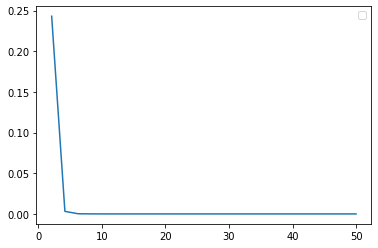

In [17]:
m =  np.linspace(epsilon,50,25)
#plt.plot(m, [c_v_x_tm1(x) for x in m])
plt.plot(m, [c_v_x_der(x) for x in m])
plt.legend()

In [18]:
def c_v_x_tm1(c):
    return consumption_stage.q_for_minimizer((c,), {'m' : 10}, {}, lambda x : c_sol.v_x({'m' : x['a']}))

In [19]:
c_v_x_tm1(9)

<xarray.DataArray 'v_x' ()>
array(0.71748045)
Coordinates:
    m        int64 1

In [20]:
def test_f(x):
    return x

In [21]:
derivative

<function scipy.misc._common.derivative(func, x0, dx=1.0, n=1, args=(), order=3)>

### Allocation stage

The allocation stage. Note that this is a trivial transition function.:

* $\alpha \in A_1 = \mathbb{R}$
* $a \in X_1 = \mathbb{R}$
* $(a, \alpha) \in Y_1 = \mathbb{R}^2$
* $\Gamma_1$ ... restricts allocation $0 \leq \alpha \leq 1$
* $F_1(a,\alpha) = 0$
* $T_1(a,\alpha) = (a, \alpha)$
* $\beta_1 = 1 $

In [22]:
allocation_stage = Stage(
    transition = lambda x, k, a : {'a' : x['a'], 'alpha' : a['alpha']}, 
    inputs = ['a'], 
    actions = ['alpha'],
    outputs = ['a', 'alpha'],
    # Using bounds instead of constraints will result in a different optimizer
    action_upper_bound = lambda x, k: (1,) , 
    action_lower_bound = lambda x, k: (0,) ,
    value_transform = np.exp,
    value_transform_inv = np.log,
    optimizer_args = {
        'method' : "trust-constr",
        'options' : {"gtol": 1e-12, "disp": False, "maxiter" : 1e10}
    },
)

Optimize portfolio allocation $\alpha$ with a more complex value function:

In [23]:
def allocation_v_y(y : Mapping[str,Any]):
    return 0

pi_star, q = allocation_stage.optimal_policy(
    {'a' : [9, 11, 20, 300, 4000, 5500]},
    v_y = allocation_v_y
)

q

Grid size: 6.0


<xarray.DataArray (a: 6)>
array([0., 0., 0., 0., 0., 0.])
Coordinates:
  * a        (a) int64 9 11 20 300 4000 5500

In [24]:
pi_star

<xarray.DataArray (a: 6)>
array([0.26437692, 0.26437692, 0.26437692, 0.26437692, 0.26437692,
       0.26437692])
Coordinates:
  * a        (a) int64 9 11 20 300 4000 5500

### Income stage

The income stage:

* $A_2 = \emptyset$
* $(a, \alpha) \in X_2 = \mathbb{R}^2$
* $m \in Y_0 = \mathbb{R}$
* Shocks:
    * $\psi \sim \text{Lognormal}(0,\sigma_\psi)$
    * $\theta \sim \text{Lognormal}(0,\sigma_\theta)$
    * $\eta \sim \text{Lognormal}(0,\sigma_\eta)$
* $F_2(a,\alpha) = 0$
* $T_2(a,\alpha) =  \frac{(\alpha \eta + (1 - \alpha) R) a + \theta}{\psi G} $ 
* $\text{discount}(\psi) = \beta L \psi^{1-\rho}$ ?? where $L$ is chance to remain alive

Requires parameters $R$ and $G$

In [25]:
R = 1.01
G = 1.02

sigma_psi = 1.05
sigma_theta = 1.15
sigma_eta = 1.1
p_live = 0.98

def income_transition(x, k, a): 
    return {'m' : ((x['alpha'] * k['eta'] + (1 - x['alpha']) * R) 
                   * x['a'] + k['theta']) 
            / (k['psi'] * G)}

income_stage = Stage(
    transition = income_transition,
    inputs = ['a', 'alpha'],
    discount = lambda x, k, a: p_live * k['psi'] ** (1 - CRRA), 
    shocks = {
        'psi' : distribution.Lognormal(0, sigma_psi),
        'theta' : distribution.Lognormal(0, sigma_theta),
        'eta' : distribution.Lognormal(0, sigma_eta),
        # 'live' : distribution.Bernoulli(p_live) ## Not implemented for now
    },
    outputs = ['m'],
    value_transform = np.exp,
    value_transform_inv = np.log,
)

TODO: Note here about the 'self-imposed binding constraint' 

In [26]:
def income_v_y(y : Mapping[str,Any]):
    return CRRAutility(y['m'], CRRA) # * 'live' ?

pi_star, q = income_stage.optimal_policy(
    {'a' : [300, 600],
     'alpha' : [0, 1.0]
    },
    {'psi' : [1., 1.1], 
     'theta' : [1., 1.1], 
     'eta' : [1., 1.1],
     # 'live' : [0, 1] 
    }, 
    v_y = income_v_y)

q

Grid size: 32


<xarray.DataArray (a: 2, alpha: 2, psi: 2, theta: 2, eta: 2)>
array([[[[[-3.10507745e-11, -3.10507745e-11],
          [-3.10099518e-11, -3.10099518e-11]],

         [[-3.10507745e-11, -3.10507745e-11],
          [-3.10099518e-11, -3.10099518e-11]]],


        [[[-3.23073093e-11, -2.20930053e-11],
          [-3.22644116e-11, -2.20663269e-11]],

         [[-3.23073093e-11, -2.20930053e-11],
          [-3.22644116e-11, -2.20663269e-11]]]],



       [[[[-1.95349366e-12, -1.95349366e-12],
          [-1.95220688e-12, -1.95220688e-12]],

         [[-1.95349366e-12, -1.95349366e-12],
          [-1.95220688e-12, -1.95220688e-12]]],


        [[[-2.03267939e-12, -1.38918771e-12],
          [-2.03132709e-12, -1.38834737e-12]],

         [[-2.03267939e-12, -1.38918771e-12],
          [-2.03132709e-12, -1.38834737e-12]]]]])
Coordinates:
  * a        (a) int64 300 600
  * alpha    (alpha) float64 0.0 1.0
  * psi      (psi) float64 1.0 1.1
  * theta    (theta) float64 1.0 1.1
  * eta      (eta) float64 1.0 1.1

Because there are no actions to optimize, the $\pi^*$ function data is 'not a number'.

In [27]:
pi_star

<xarray.DataArray (a: 2, alpha: 2, psi: 2, theta: 2, eta: 2)>
array([[[[[nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan]]],


        [[[nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan]]]],



       [[[[nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan]]],


        [[[nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan]]]]])
Coordinates:
  * a        (a) int64 300 600
  * alpha    (alpha) float64 0.0 1.0
  * psi      (psi) float64 1.0 1.1
  * theta    (theta) float64 1.0 1.1
  * eta      (eta) float64 1.0 1.1

In [28]:
i_sol = income_stage.solve(
    {'a' : [0, 500, 1000], 'alpha' : [0, 0.5, 1.0]},
    {
        'psi' : 4, 
        'theta' : 4, 
        'eta' : 4,
     # 'live' : [0, 1] 
    }, income_v_y)

i_sol.dataset

Grid size: 576


<xarray.Dataset>
Dimensions:  (a: 3, alpha: 3, psi: 4, theta: 4, eta: 4)
Coordinates:
  * a        (a) int64 0 500 1000
  * alpha    (alpha) float64 0.0 0.5 1.0
  * psi      (psi) float64 0.2937 0.7257 1.435 4.487
  * theta    (theta) float64 0.2638 0.7054 1.489 5.291
  * eta      (eta) float64 0.2783 0.7155 1.462 4.869
Data variables:
    v_x      (a, alpha) float64 -13.98 -13.98 -13.98 ... -5.283e-13 -1.102e-11
    v_x_der  (a, alpha) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
    pi*      (a, alpha, psi, theta, eta) float64 nan nan nan nan ... nan nan nan
    q        (a, alpha, psi, theta, eta) float64 -54.79 -54.79 ... -4.696e-16

Note that solving this stage involves computing over a large grid, as it is the product of the sizes of the input and shock spaces.

In [29]:
i_sol = income_stage.solve(
    {'a' : [epsilon, 250, 500, 750, 1000], 'alpha' : [epsilon, 0.2, 0.4, 0.6, 0.8, 1.0]},
    {
        'psi' : 4, 
        'theta' : 4, 
        'eta' : 4,
     # 'live' : [0, 1] 
    }, income_v_y)

i_sol.v_x({'a' : 300, 'alpha' : 0.25})

Grid size: 1920


<xarray.DataArray 'v_x' ()>
array(-5.75831605e-11)
Coordinates:
    a        int64 300
    alpha    float64 0.25

In [30]:
i_sol.dataset.data_vars

Data variables:
    v_x      (a, alpha) float64 -13.96 -13.95 -13.95 ... -2.204e-12 -1.102e-11
    v_x_der  (a, alpha) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    pi*      (a, alpha, psi, theta, eta) float64 nan nan nan nan ... nan nan nan
    q        (a, alpha, psi, theta, eta) float64 -54.71 -54.71 ... -4.696e-16

#### Alternative Composition: splitting independent shocks

Above, we found that the income stage had a very large grid because of the size of the shock space. One optimization we can do with generalized Bellman stages is break down the effects of the independent shock into a separate stages.

#### Investing stage

The investing stage is when the consumer realizes risk-free and risky returns on their savings:

* $A = \emptyset$
* $(a, \alpha) \in X = \mathbb{R}^2$
* $b \in Y = \mathbb{R}$
* Shocks:
    * $\eta \sim \text{Lognormal}(0,\sigma_\eta)$
* $F(a,\alpha) = 0$
* $T(a,\alpha) =  \alpha \eta + (1 - \alpha) R$
* $\beta = L$

Requires parameters $R$ and $L$.

#### Labor stage

The labor stage is when the consumer experiences permanent and transient income shocks.

* $A = \emptyset$
* $a_\eta \in X = \mathbb{R}$
* $a_\theta \in Y_0 = \mathbb{R}$
* Shocks:
    * $\theta \sim \text{Lognormal}(0,\sigma_\theta)$
    * $\psi \sim \text{Lognormal}(0,\sigma_\psi)$
* $F(a,\alpha) = 0$
* $T(a,\alpha) =  (b + \theta) / (G\psi)$ 
* $\beta(\psi) = \psi^{1 - \rho}$ 

In [31]:
def investing_transition(x, k, a): 
    return {'b' : ((x['alpha'] * k['eta'] + (1 - x['alpha']) * R)) * x['a']}

investing_stage = Stage(
    transition = investing_transition,
    inputs = ['a', 'alpha'],
    discount = p_live, 
    shocks = {
        'eta' : distribution.Lognormal(0, sigma_eta),
    },
    outputs = ['b'],
)

def labor_transition(x, k, a):
    return  {'m' : (x['b'] + k['theta']) / ( k['psi'] * G)}

labor_stage = Stage(
    transition = labor_transition,
    inputs = ['b'],
    shocks = {
        'theta' : distribution.Lognormal(0, sigma_theta),
        'psi' : distribution.Lognormal(0, sigma_psi),
        # 'live' : distribution.Bernoulli(p_live) ## Not implemented for now
    },
    outputs = ['m'],
    discount = lambda x, k, a: k['psi'] ** (1 - CRRA), 
)

### Forward Simulation - single stage

Given:
 - a stage $(\vec{X}, P_\vec{K}, \vec{A}, \Gamma, F, \vec{Y}, T, \beta)$ 
 - a policy $\pi: \vec{X} \times \vec{K} \rightarrow \vec{A}$
 - input states $\vec{x}$
 
The stage can be Monte Carlo simulated forward by:
 - Sampling $\vec{k} \sim P_\vec{K}$
 - Determining actions $\vec{a} = \pi(\vec{x}, \vec{k})$
 - Computing reward $F(\vec{x}, \vec{k}, \vec{a})$ and discount factor $\beta(\vec{x}, \vec{k}, \vec{a})$
 - Transitioning to ouput state $\vec{y} = T(\vec{x}, \vec{k}, \vec{a})$

In [32]:
c_sol.pi_star({'m' : 10},{})

{'c': 10.0}

In [33]:
simulate_stage(consumption_stage, {'m' : 10}, c_sol.pi_star)

({}, {'c': 10.0}, {'a': 0.0}, -2.5e-05)

In [34]:
simulate_stage(income_stage, {'a' : 10, 'alpha' : 0.5}, i_sol.pi_star)

({'psi': 2.178575728752181,
  'theta': 2.3462786080287055,
  'eta': 2.2608727581051067},
 {},
 {'m': 8.41557302501419},
 0)

## Solving in sequence

We will now solve these stages backwards in sequence, chaining the input value function to one stage into the output value function of the previous stage.

In [35]:
x_grid = np.linspace(epsilon,25,32)
alpha_grid = np.linspace(0,1,16)

i_shock_approx_params = {
            'eta' : 9,
        }

l_shock_approx_params = {
            'psi' : 9, 
            'theta' : 9, 
        }

We are going to start with the final consumption stage, because after this stage the agent has no more opportunities to gain utility.

#### Terminal Consumption

Solve the growth stage with the terminal utility of $0$.

In [36]:
def consumption_v_y_terminated(y : Mapping[str,Any]):
    return 0

c_sol = consumption_stage.solve(
    {'m' : x_grid},
    {},
    v_y = consumption_v_y_terminated
)

Grid size: 32.0


The consumption function looks right! Consume all the resources!

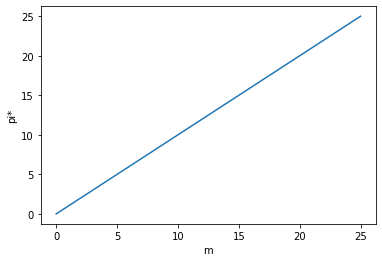

In [37]:
c_sol.dataset.data_vars['pi*'].plot(x='m')

The value function data does not support a good linear interpolation because the true function is so curved.

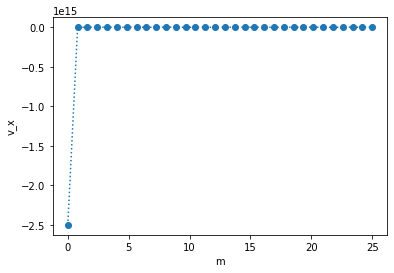

In [38]:
c_sol.dataset.data_vars['v_x'].plot(marker="o",ls=":",x='m')

But we have instructed the stage to transform this function before interpolating it, which brings back some of the curvature and gives us values that approach $-\infty$ as consumption goes to $0$.

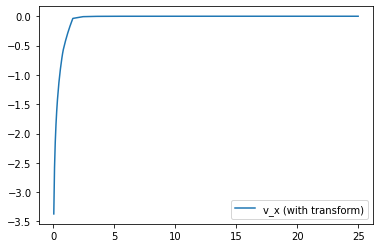

In [39]:
m = np.linspace(-5,25,500)
plt.plot(m, c_sol.v_x({'m' : m}), label = 'v_x (with transform)')
plt.legend()

Note that because of recurving, the marginal value function is not a step function.
However, it is still not smooth, and the abrupt changes will reduce the quality of further computations.

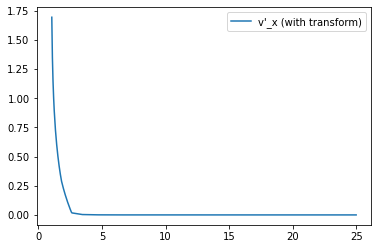

In [40]:
from scipy.misc import derivative

def c_sol_vP_x(mi):
    return derivative(
        lambda m: c_sol.v_x({'m' : m}),
        mi
    )

m = np.linspace(1,25,500)
plt.plot(m, [c_sol_vP_x(mi) for mi in m], label = 'v\'_x (with transform)')
#c_sol.dataset.map(np.exp).data_vars['v_x'].plot(marker="o",ls=":",x='m')
#plt.plot(m, sols[0].v_x({'m' :m}), label = 'v_x')
plt.legend()

In [41]:
c_sol

<xarray.Dataset>
Dimensions:  (m: 33)
Coordinates:
  * m        (m) float64 0.0 0.0001 0.8065 1.613 ... 22.58 23.39 24.19 25.0
Data variables:
    v_x      (m) float64 -inf -2.5e+15 -0.5908 ... -7.297e-07 -6.4e-07
    v_x_der  (m) float64 inf 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    pi*      (m) float64 0.0 0.0001 0.8065 1.613 ... 22.58 23.39 24.19 25.0
    q        (m) float64 -inf -2.5e+15 -0.5908 ... -7.297e-07 -6.4e-07

#### T-1 Income

Solve the growth stage with the value function from the previous step.

In [42]:
l_sol = labor_stage.solve(
    {'b' : x_grid},
    l_shock_approx_params,
    v_y = c_sol.v_x
)

i_sol = investing_stage.solve(
    {'a' : x_grid, 'alpha' : alpha_grid},
    i_shock_approx_params,
    v_y = l_sol.v_x
)

Grid size: 2592
Grid size: 4608


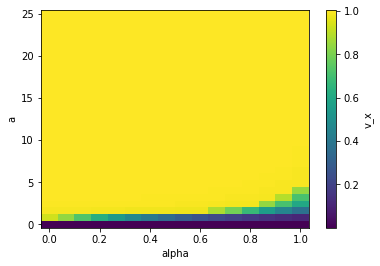

In [43]:
i_sol.dataset.map(np.exp).data_vars['v_x'].plot(x=None)

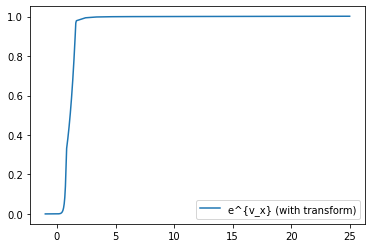

In [44]:
m = np.linspace(-1,25,500)
plt.plot(m, np.exp(i_sol.v_x({'a' : m, 'alpha' : 0.5})), label = 'e^{v_x} (with transform)')
plt.legend()

In [45]:
i_sol

<xarray.Dataset>
Dimensions:  (a: 32, alpha: 16, eta: 9)
Coordinates:
  * a        (a) float64 0.0001 0.8065 1.613 2.419 ... 22.58 23.39 24.19 25.0
  * alpha    (alpha) float64 0.0 0.06667 0.1333 0.2 ... 0.8 0.8667 0.9333 1.0
  * eta      (eta) float64 0.1673 0.3454 0.5242 0.7354 ... 1.929 2.955 7.449
Data variables:
    v_x      (a, alpha) float64 -8.896 -8.896 -8.896 ... 0.002551 0.002611
    v_x_der  (a, alpha) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    pi*      (a, alpha, eta) float64 nan nan nan nan nan ... nan nan nan nan nan
    q        (a, alpha, eta) float64 -8.896 -8.896 -8.896 ... 0.004438 0.01157

#### T-1 Allocation

Solve allocation stage with value function from previous step.

In [46]:
a_sol = allocation_stage.solve(
    {'a' : x_grid},
    {},
    v_y = i_sol.v_x
)

Grid size: 32.0


In [47]:
a_sol

<xarray.Dataset>
Dimensions:  (a: 32)
Coordinates:
  * a        (a) float64 0.0001 0.8065 1.613 2.419 ... 22.58 23.39 24.19 25.0
Data variables:
    v_x      (a) float64 -8.895 -0.07153 -0.009791 ... 0.00241 0.002513 0.002611
    v_x_der  (a) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    pi*      (a) float64 0.9986 0.0001017 0.0007586 ... 0.9999 0.9997 0.9997
    q        (a) float64 -8.895 -0.07153 -0.009791 ... 0.00241 0.002513 0.002611

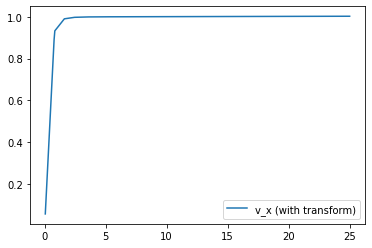

In [48]:
m = np.linspace(-5,25,500)
plt.plot(m, np.exp(a_sol.v_x({'a' : m})), label = 'v_x (with transform)')
#c_sol.dataset.map(np.exp).data_vars['v_x'].plot(marker="o",ls=":",x='m')
#plt.plot(m, sols[0].v_x({'m' :m}), label = 'v_x')
plt.legend()

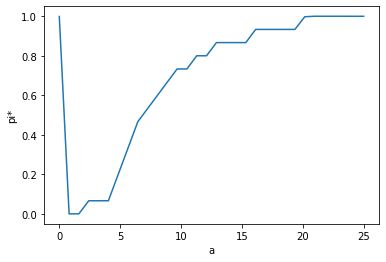

In [49]:
a_sol.dataset.data_vars['pi*'].plot(x=None)

#### T-2 Consumption

Now, let's do the next round.

In [50]:
c_sol = consumption_stage.solve(
    {'m' : x_grid},
    {},
    v_y = a_sol.v_x
)

Grid size: 32.0


In [51]:
c_sol

<xarray.Dataset>
Dimensions:  (m: 33)
Coordinates:
  * m        (m) float64 0.0 0.0001 0.8065 1.613 ... 22.58 23.39 24.19 25.0
Data variables:
    v_x      (m) float64 -inf -2.5e+15 -3.014 ... 0.001386 0.001485 0.00158
    v_x_der  (m) float64 inf 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    pi*      (m) float64 0.0 0.0001 0.6735 0.9333 ... 6.02 6.026 6.09 6.135
    q        (m) float64 -inf -2.5e+15 -3.014 ... 0.001386 0.001485 0.00158

The roughness of this consumption function is due to the fact that the target $v_y$ function is interpolated.

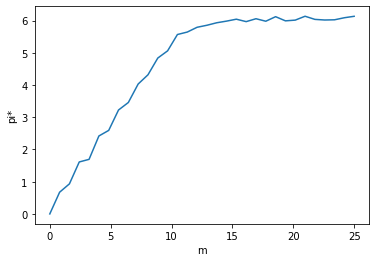

In [52]:
c_sol.dataset.data_vars['pi*'].plot(x='m')

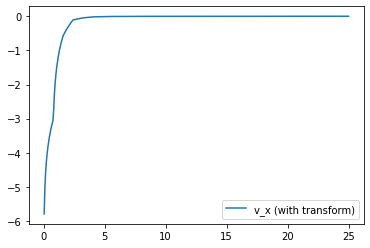

In [53]:
m = np.linspace(-5,25,500)
plt.plot(m, c_sol.v_x({'m' : m}), label = 'v_x (with transform)')
plt.legend()

In [54]:
l_sol = labor_stage.solve(
    {'b' : x_grid},
    l_shock_approx_params,
    v_y = c_sol.v_x
)

i_sol = investing_stage.solve(
    {'a' : x_grid, 'alpha' : alpha_grid},
    i_shock_approx_params,
    v_y = l_sol.v_x
)

Grid size: 2592
Grid size: 4608


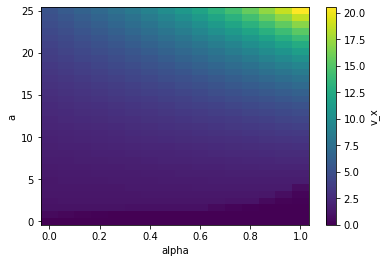

In [55]:
i_sol.dataset.map(np.exp).data_vars['v_x'].plot(x=None)

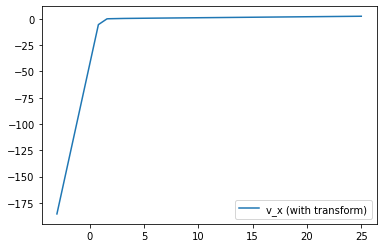

In [56]:
m = np.linspace(-3,25,500)
plt.plot(m, i_sol.v_x({'a' : m, 'alpha' : 0.5}), label = 'v_x (with transform)')
plt.legend()

In [57]:
a_sol = allocation_stage.solve(
    {'a' : x_grid},
    {},
    v_y = i_sol.v_x
)

Grid size: 32.0


In [58]:
a_sol

<xarray.Dataset>
Dimensions:  (a: 32)
Coordinates:
  * a        (a) float64 0.0001 0.8065 1.613 2.419 ... 22.58 23.39 24.19 25.0
Data variables:
    v_x      (a) float64 -43.74 -0.6322 -0.01423 0.1536 ... 2.824 2.922 3.02
    v_x_der  (a) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    pi*      (a) float64 0.9997 0.0001086 0.06667 0.4 ... 0.9999 0.9999 0.9999
    q        (a) float64 -43.74 -0.6322 -0.01423 0.1536 ... 2.824 2.922 3.02

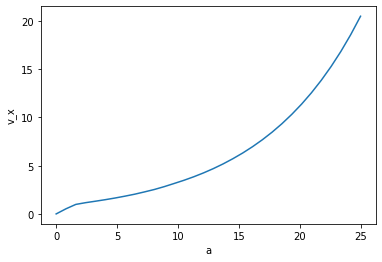

In [59]:
a_sol.dataset.map(np.exp).data_vars['v_x'].plot(x=None)

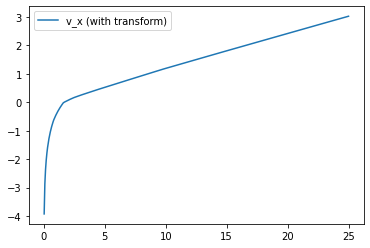

In [60]:
m = np.linspace(-3,25,500)
plt.plot(m, a_sol.v_x({'a' : m}), label = 'v_x (with transform)')
#c_sol.dataset.map(np.exp).data_vars['v_x'].plot(marker="o",ls=":",x='m')
#plt.plot(m, sols[0].v_x({'m' :m}), label = 'v_x')
plt.legend()

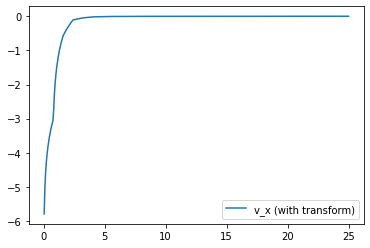

In [61]:
m = np.linspace(-5,25,500)
plt.plot(m, c_sol.v_x({'m' : m}), label = 'v_x (with transform)')
plt.legend()

One more time for good measure!

In [62]:
l_sol = labor_stage.solve(
    {'b' : x_grid},
    l_shock_approx_params,
    v_y = c_sol.v_x
)

i_sol = investing_stage.solve(
    {'a' : x_grid, 'alpha' : alpha_grid},
    i_shock_approx_params,
    v_y = l_sol.v_x
)

Grid size: 2592
Grid size: 4608


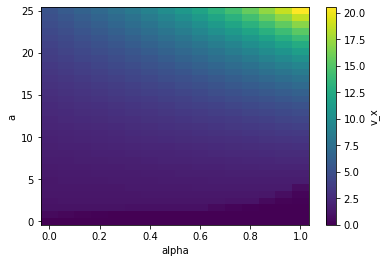

In [63]:
i_sol.dataset.map(np.exp).data_vars['v_x'].plot(x=None)

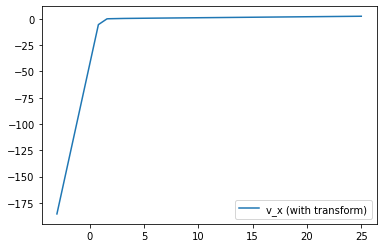

In [64]:
m = np.linspace(-3,25,500)
plt.plot(m, i_sol.v_x({'a' : m, 'alpha' : 0.5}), label = 'v_x (with transform)')
plt.legend()

In [65]:
a_sol = allocation_stage.solve(
    {'a' : x_grid},
    {},
    v_y = i_sol.v_x
)

Grid size: 32.0


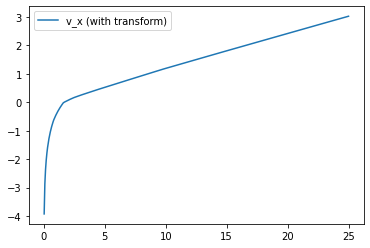

In [66]:
m = np.linspace(-3,25,500)
plt.plot(m, a_sol.v_x({'a' : m}), label = 'v_x (with transform)')
#c_sol.dataset.map(np.exp).data_vars['v_x'].plot(marker="o",ls=":",x='m')
#plt.plot(m, sols[0].v_x({'m' :m}), label = 'v_x')
plt.legend()

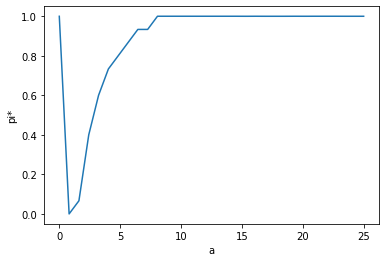

In [67]:
a_sol.dataset.data_vars['pi*'].plot(x=None)

In [68]:
c_sol = consumption_stage.solve(
    {'m' : x_grid},
    {},
    v_y = a_sol.v_x
)

Grid size: 32.0


In [69]:
c_sol

<xarray.Dataset>
Dimensions:  (m: 33)
Coordinates:
  * m        (m) float64 0.0 0.0001 0.8065 1.613 ... 22.58 23.39 24.19 25.0
Data variables:
    v_x      (m) float64 -inf -4.237e+74 -3.553 -1.101 ... 2.488 2.582 2.676
    v_x_der  (m) float64 inf 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    pi*      (m) float64 0.0 1.559e-19 0.6734 0.9333 ... 1.525 1.525 1.526 1.525
    q        (m) float64 nan -4.237e+74 -3.553 -1.101 ... 2.488 2.582 2.676

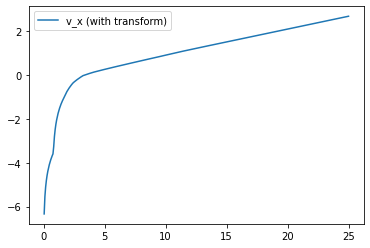

In [70]:
m = np.linspace(-5,25,500)
plt.plot(m, c_sol.v_x({'m' : m}), label = 'v_x (with transform)')
plt.legend()

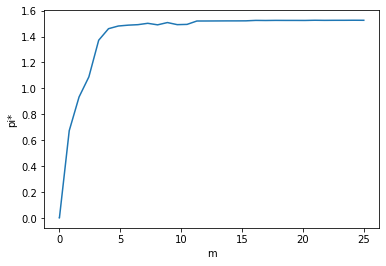

In [71]:
c_sol.dataset.data_vars['pi*'].plot(x='m')

## Backward Induction Solver

We chain together the stages and iterative solve each stage backwards, feeding $v_x$ into $v_y$, until convergence.

We will use a very coarse grid to start with, for demonstration purposes.

In [72]:
stages_data = [
    {
        'stage' : consumption_stage,
        'x_grid' : {'m' : np.linspace(epsilon*2,25,40)},
        'optimizer_args' :{
            'a0f' : lambda x: x['m'] - epsilon
        }
    },
    {
        'stage' : allocation_stage,
        'x_grid' : {'a' : np.linspace(epsilon*2,25,35)},
        'optimizer_args' :{}
    },
    {
        'stage' : investing_stage,
        'x_grid' : {
            'a' : np.linspace(epsilon*2,25,25),
            'alpha' : np.linspace(0,1,15)
        },
        'shock_approx_params' : {
            'eta' : 11,
        },
    },
    {
        'stage' : labor_stage,
        'x_grid' : {
            'b' : np.linspace(epsilon*2,25,35),
        },
        'shock_approx_params' : {
            'psi' : 9, 
            'theta' : 9, 
        },
    }
]

We can then solve each stage with backwards induction. Let's do this for one time-period, starting with the trivial terminal value function $v_y = 0$.

In [73]:
def growth_v_y_terminal(y : Mapping[str,Any]):
    return 0

In [74]:
sols = backwards_induction(stages_data * 2, growth_v_y_terminal)

7: X: ['b'], K: ['theta', 'psi'], A: [], Y: ['m']
Grid size: 2835
Time to backwards induce v_x: 0:00:01.520535
6: X: ['a', 'alpha'], K: ['eta'], A: [], Y: ['b']
Grid size: 4125
Time to backwards induce v_x: 0:00:15.654576
5: X: ['a'], K: [], A: ['alpha'], Y: ['a', 'alpha']
Grid size: 35.0
Time to backwards induce v_x: 0:00:01.465340
4: X: ['m'], K: [], A: ['c'], Y: ['a']
Grid size: 40.0
Time to backwards induce v_x: 0:00:00.294638
3: X: ['b'], K: ['theta', 'psi'], A: [], Y: ['m']
Grid size: 2835
Time to backwards induce v_x: 0:00:12.288461
2: X: ['a', 'alpha'], K: ['eta'], A: [], Y: ['b']
Grid size: 4125
Time to backwards induce v_x: 0:00:16.216774
1: X: ['a'], K: [], A: ['alpha'], Y: ['a', 'alpha']
Grid size: 35.0
Time to backwards induce v_x: 0:00:20.171222
0: X: ['m'], K: [], A: ['c'], Y: ['a']
Grid size: 40.0
Optimization failure at {'m': 0.0002}, {}.
 final_simplex: (array([[0.0001],
       [0.0001]]), array([nan, nan]))
           fun: nan
       message: 'Maximum number of itera

Optimization failure at {'m': 14.102651282051283}, {}.
 final_simplex: (array([[14.10255128],
       [14.10255128]]), array([nan, nan]))
           fun: nan
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 2999
           nit: 1000
        status: 2
       success: False
             x: array([14.10255128])
Optimization failure at {'m': 14.743671794871796}, {}.
 final_simplex: (array([[14.74357179],
       [14.74357179]]), array([nan, nan]))
           fun: nan
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 2999
           nit: 1000
        status: 2
       success: False
             x: array([14.74357179])
Optimization failure at {'m': 15.384692307692308}, {}.
 final_simplex: (array([[15.38459231],
       [15.38459231]]), array([nan, nan]))
           fun: nan
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 2999
           nit: 1000
        status: 2
       success: False
           

In [75]:
sols[0].v_x({'m' : 3})

<xarray.DataArray 'v_x' ()>
array(nan)
Coordinates:
    m        int64 3

In [76]:
sols[0].dataset.data_vars['v_x']

<xarray.DataArray 'v_x' (m: 41)>
array([-inf,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])
Coordinates:
  * m        (m) float64 0.0 0.0002 0.6412 1.282 ... 23.08 23.72 24.36 25.0

Now we can run backwards induction with the new (penultimate) value function:

**TODO: This isn't working yet. Getting 'Maximum number of iterations has been exceeded' errors when solving later consumption stages. This must be due to errors in the value function, which I'm working to resolve through generalization of more MicroSolvingDSOP steps. - SB**

In [77]:
#sols = backwards_induction(stages_data * 2, sols[0].v_x)

Now we have a new consumption function!

It is not smooth because of the coarseness of the discretization grid.

In [78]:
#sols[0].dataset.data_vars['pi*'].plot(x='m')